In [ ]:
!pip install opendatasets pandas numpy tensorflow-hub keras tensorflow matplotlib scipy scikit-learn

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import opendatasets as od
from scipy.stats import pearsonr
from string import punctuation
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder,OrdinalEncoder
from sklearn.preprocessing import StandardScaler
import math

In [2]:
import tensorflow_hub as tfh

In [3]:
def removepunc(data):
  for i in punctuation:
    if i==".":
      data=data.replace(i," ")
    else:
      data=data.replace(i,"")
  data=data.replace("\n","")

  return data

def masknum(data):
  data=removepunc(data)
  words=data.split(" ")
  for k,i in enumerate(words):
    if i.isnumeric():
      words[k]="@"
  return " ".join(words)

def vocab(data):
  vocab=[]
  for i in data:
    words=i.split(" ")
    for x in words:
      vocab.append(x.lower())
  return set(vocab)

def standard(data):
  data=StandardScaler().fit_transform(data)
  return data

def roundielts(x):
  if  (x*10)%10 >2.5 and  x*10%10 <5:
    return math.floor(x) + 0.5
  elif x*10%10 >5:
    return math.ceil(x)
  else:
    return math.floor(x)
  


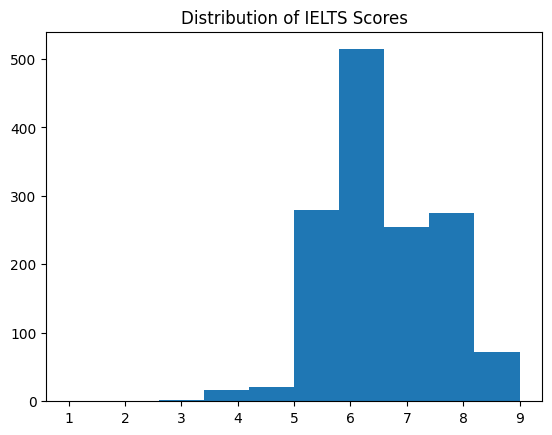

In [4]:
data=pd.read_csv("ielts_writing_dataset.csv")
classnum=len(data["Overall"].unique())
data.groupby("Task_Type").agg({"Task_Type":"count"})
plt.hist(data["Overall"])
plt.title("Distribution of IELTS Scores")
plt.show()

In [5]:
data.groupby("Overall").agg({"Overall":"count"}) #This dataset is an unbalanced set.


,Overall
Overall,
1.0,1
3.0,2
3.5,5
4.0,11
4.5,21
5.0,104
5.5,176
6.0,264
6.5,250


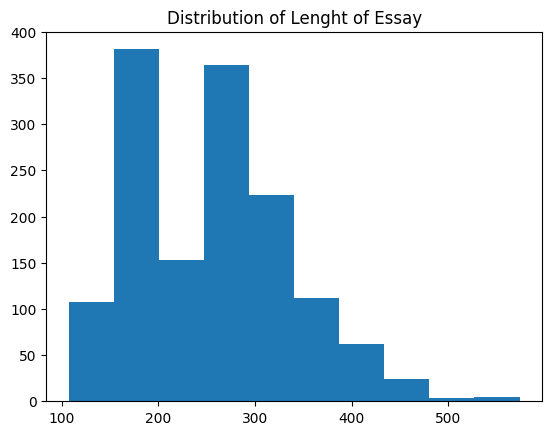

In [6]:
data["length"]=data["Essay"].apply(lambda x: len(x.split(" ")))
plt.hist(data["length"])
plt.title("Distribution of Lenght of Essay")
plt.show()

In [7]:
data.groupby(["Overall"]).agg({"length":"mean"}) # Essays that longer than 258 words got at least 7, it seems a correlation between score and length

,length
Overall,
1.0,277.000000
3.0,192.500000
3.5,137.200000
4.0,211.636364
4.5,217.619048
5.0,231.509615
5.5,226.011364
6.0,246.022727
6.5,245.872000


In [8]:
from keras.utils import to_categorical

In [9]:
data2=data.copy()
data2["text"]=data2["Essay"].apply(masknum) #We are masking the numerical values and removing punctuation
data2["text"][4]
data2["Overall2"]=data2["Overall"].apply(lambda x: str(x))
X=data2[["text","Task_Type"]]
y=data2["Overall2"]

cats=y.unique()
oe=OrdinalEncoder()
y2=oe.fit_transform(np.array(y)[:,np.newaxis])
y3=to_categorical(y2,num_classes=classnum)


In [10]:
from tensorflow.keras.layers import Embedding, TextVectorization

In [11]:
X_train,X_test,y_train,y_test=train_test_split(X,y3,random_state=42,test_size=0.2) #Because of size of the data set, 10% of test set will be used as validation set
max_vocab_length=len(vocab(data2["text"]))
max_length=int(np.percentile(data2["length"],96))
vectorizer=TextVectorization(max_tokens=max_vocab_length,output_sequence_length=max_length,standardize='lower_and_strip_punctuation')
vectorizer.adapt(X_train["text"])
embedding=Embedding(input_dim=len(vectorizer.get_vocabulary()),output_dim=128,mask_zero=True)

In [12]:
import tensorflow as tf
import tensorflow_hub as tfh
from tensorflow.keras import layers, Model

class USELayer(layers.Layer):
    def __init__(self, **kwargs):
        super(USELayer, self).__init__(**kwargs)
        self.use = tfh.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4", trainable=False)

    def call(self, inputs):
        return self.use(inputs)

def createuse():
    sentence_inputs = layers.Input(shape=(), dtype=tf.string)
    sentence_encoded = USELayer()(sentence_inputs)
    sentence_ = layers.Dense(16, activation="relu")(sentence_encoded)
    sentence_output = layers.Dropout(0.5)(sentence_)
    sentence_model = Model(inputs=sentence_inputs, outputs=sentence_output)

    return sentence_model

def createmlp():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(32, activation="relu", input_shape=(1,)),
        tf.keras.layers.Dense(16, activation="relu")
    ])
    return model

# Create the MLP and USE models
mlp = createmlp()
rnn = createuse()

# Define the inputs
mlp_input = layers.Input(shape=(1,), dtype=tf.float32)  # Adjust the input shape as needed
rnn_input = layers.Input(shape=(), dtype=tf.string)

# Get the outputs
mlp_output = mlp(mlp_input)
rnn_output = rnn(rnn_input)



c:\Users\Asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:

# Concatenate the outputs
combinedInput = layers.concatenate([mlp_output, rnn_output])
x = layers.Dense(32, activation="relu")(combinedInput)
outputs = layers.Dense(14, activation="softmax", name="outputs")(x)


In [15]:

# Create the hybrid model
modelhybridclass = Model(inputs=[mlp_input, rnn_input], outputs=outputs, name="HybridClassificationModel")

# Plot the model
# tf.keras.utils.plot_model(modelhybridclass, to_file="model.png", show_shapes=True)

In [17]:
es=tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=10)
modelhybridclass.compile(loss=tf.keras.losses.categorical_crossentropy,optimizer=tf.keras.optimizers.Adam(),metrics=["accuracy"])

In [19]:
historyhybridclass=modelhybridclass.fit(x=[X_train["Task_Type"],X_train["text"]],epochs=150,y=y_train,validation_data=([X_test["Task_Type"],X_test["text"]],y_test),validation_steps=len(y_test)-1)

Epoch 1/150
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.2363 - loss: 1.9997 - val_accuracy: 0.2195 - val_loss: 2.0682
Epoch 2/150
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.2743 - loss: 1.9835 - val_accuracy: 0.2369 - val_loss: 2.0587
Epoch 3/150
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.2693 - loss: 1.9896 - val_accuracy: 0.2474 - val_loss: 2.0547
Epoch 4/150
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.2919 - loss: 1.9700 - val_accuracy: 0.2439 - val_loss: 2.0538
Epoch 5/150
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.3071 - loss: 1.9325 - val_accuracy: 0.2509 - val_loss: 2.0562
Epoch 6/150
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.3218 - loss: 1.8885 - val_accuracy: 0.2265 - val_loss: 2.0493
Epoch 7/150
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.3232 - loss: 1.9215 - val_accuracy: 0.2648 - val_loss: 2.0546
Epoch 8/150
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.3070 - loss: 1.9031 - val_accuracy: 0.

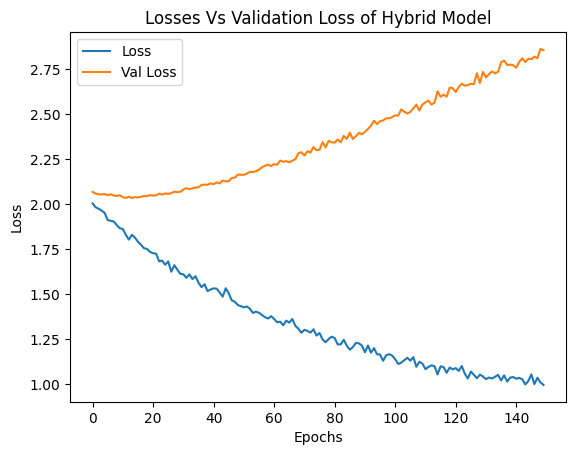

In [20]:
plt.plot(historyhybridclass.history["loss"])
plt.plot(historyhybridclass.history["val_loss"])
plt.title("Losses Vs Validation Loss of Hybrid Model")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss","Val Loss"])

In [21]:
#This model will take only the text as input
input=tf.keras.layers.Input(shape=[],name="Input",dtype="string")
x=vectorizer(input)
x=embedding(x)
x=tf.keras.layers.LSTM(64)(x)
outputs=tf.keras.layers.Dense(14,activation="softmax",name="output")(x)
modelrnnclass=tf.keras.Model(input,outputs,name="RNNClassificationModel")

In [22]:
modelrnnclass.compile(loss=tf.keras.losses.categorical_crossentropy,optimizer=tf.keras.optimizers.Adam(),metrics=["accuracy"])
historyrnnclass=modelrnnclass.fit(X_train["text"],epochs=150,y=y_train,validation_data=(X_test["text"],y_test))

Epoch 1/150
36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 199ms/step - accuracy: 0.1427 - loss: 2.5237 - val_accuracy: 0.1916 - val_loss: 2.1342
Epoch 2/150
36/36 ━━━━━━━━━━━━━━━━━━━━ 9s 248ms/step - accuracy: 0.1835 - loss: 2.1697 - val_accuracy: 0.1951 - val_loss: 2.1128
Epoch 3/150
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 212ms/step - accuracy: 0.2571 - loss: 2.0831 - val_accuracy: 0.2509 - val_loss: 2.0787
Epoch 4/150
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 210ms/step - accuracy: 0.4614 - loss: 1.8813 - val_accuracy: 0.2544 - val_loss: 2.0752
Epoch 5/150
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 217ms/step - accuracy: 0.6292 - loss: 1.3961 - val_accuracy: 0.2787 - val_loss: 2.2079
Epoch 6/150
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 194ms/step - accuracy: 0.7971 - loss: 0.9303 - val_accuracy: 0.3066 - val_loss: 2.3395
Epoch 7/150
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 192ms/step - accuracy: 0.8621 - loss: 0.5962 - val_accuracy: 0.2962 - val_loss: 2.4440
Epoch 8/150
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 212ms/step - accuracy: 0.9245 - loss: 0.3569 - val_acc

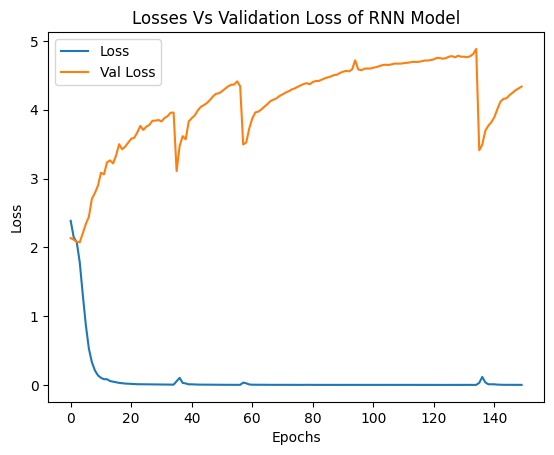

In [23]:
plt.plot(historyrnnclass.history["loss"])
plt.plot(historyrnnclass.history["val_loss"])
plt.title("Losses Vs Validation Loss of RNN Model")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss","Val Loss"])

In [24]:
import tensorflow as tf
import tensorflow_hub as tfh
from tensorflow.keras import layers, Model

# Define the custom layer that wraps the TensorFlow Hub model
class USELayer(layers.Layer):
    def __init__(self, **kwargs):
        super(USELayer, self).__init__(**kwargs)
        self.use = tfh.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4", trainable=False)

    def call(self, inputs):
        return self.use(inputs)

# Create the model using the custom layer
def create_model():
    input = tf.keras.layers.Input(shape=(), dtype=tf.string, name="Input")
    x = USELayer()(input)
    x = tf.keras.layers.Dense(64, activation="relu")(x)
    outputs = tf.keras.layers.Dense(14, activation="softmax", name="output")(x)
    model = tf.keras.Model(inputs=input, outputs=outputs, name="PreClassificationModel")
    return model

# Create and compile the model
modelpreclass = create_model()
modelpreclass.compile(loss=tf.keras.losses.categorical_crossentropy,
                      optimizer=tf.keras.optimizers.Adam(),
                      metrics=["accuracy"])

# Display the model summary
modelpreclass.summary()

# Assuming X_train, y_train, X_test, and y_test are already defined and preprocessed
# Fit the model to the training data
historypreclass = modelpreclass.fit(X_train["text"], 
                                    epochs=150, 
                                    y=y_train, 
                                    validation_data=(X_test["text"], y_test))


Model: "PreClassificationModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None)                 │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ use_layer_1 (USELayer)          │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 14)             │           910 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,742 (131.80 KB)

 Trainable params: 33,742 (131.80 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.1318 - loss: 2.5782 - val_accuracy: 0.1986 - val_loss: 2.3426
Epoch 2/150
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.2447 - loss: 2.2609 - val_accuracy: 0.1986 - val_loss: 2.1479
Epoch 3/150
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.2550 - loss: 2.0884 - val_accuracy: 0.1986 - val_loss: 2.1136
Epoch 4/150
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.2942 - loss: 2.0694 - val_accuracy: 0.2125 - val_loss: 2.0977
Epoch 5/150
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.2957 - loss: 2.0264 - val_accuracy: 0.2230 - val_loss: 2.0893
Epoch 6/150
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.3176 - loss: 1.9581 - val_accuracy: 0.2300 - val_loss: 2.0808
Epoch 7/150
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.3284 - loss: 1.9404 - val_accuracy: 0.2265 - val_loss: 2.0766
Epoch 8/150
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.3752 - loss: 1.8821 - val_accuracy: 0.

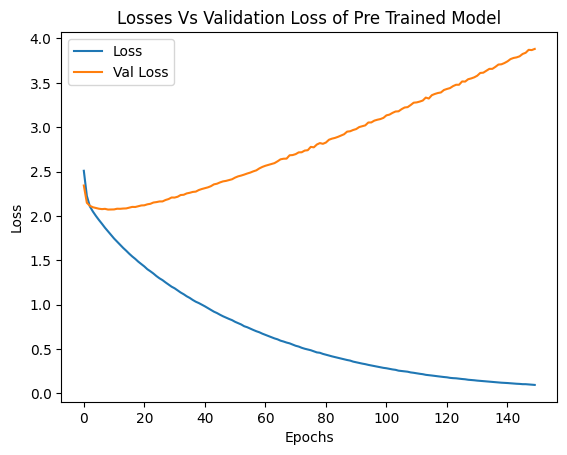

In [26]:
plt.plot(historypreclass.history["loss"])
plt.plot(historypreclass.history["val_loss"])
plt.title("Losses Vs Validation Loss of Pre Trained Model")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss","Val Loss"])

In [29]:
y2=data2["Overall"].astype("float32")
X_train,X_test,y_train,y_test=train_test_split(X,y2,random_state=42,test_size=0.2)
es=tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=5)


In [31]:
import tensorflow as tf
import tensorflow_hub as tfh
from tensorflow.keras import layers, Model

class USELayer(layers.Layer):
    def __init__(self, **kwargs):
        super(USELayer, self).__init__(**kwargs)
        self.use = tfh.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4", trainable=False)

    def call(self, inputs):
        return self.use(inputs)

def createuse():
    sentence_inputs = layers.Input(shape=(), dtype=tf.string)
    sentence_encoded = USELayer()(sentence_inputs)
    sentence_ = layers.Dense(16, activation="relu")(sentence_encoded)
    sentence_output = layers.Dropout(0.5)(sentence_)
    sentence_model = Model(inputs=sentence_inputs, outputs=sentence_output)

    return sentence_model

def createmlp():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(32, activation="relu", input_shape=(1,)),
        tf.keras.layers.Dense(16, activation="relu")
    ])
    return model

# Create the MLP and USE models
mlp = createmlp()
rnn = createuse()

# Define the inputs
mlp_input = layers.Input(shape=(1,), dtype=tf.float32)  # Adjust the input shape as needed
rnn_input = layers.Input(shape=(), dtype=tf.string)

# Get the outputs
mlp_output = mlp(mlp_input)
rnn_output = rnn(rnn_input)

# Concatenate the outputs
combinedInput = layers.concatenate([mlp_output, rnn_output])
x = layers.Dense(32, activation="relu")(combinedInput)
outputs = layers.Dense(14, activation="softmax", name="outputs")(x)

In [34]:
modelhybridreg=tf.keras.Model(inputs=[mlp.input,rnn.input],outputs=outputs,name="HybridRegressionModel")

In [36]:
modelhybridreg.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)


In [40]:
historyhybridreg=modelhybridreg.fit(x=[X_train["Task_Type"],X_train["text"]],epochs=150,y=y_train,validation_data=([X_test["Task_Type"],X_test["text"]],y_test),validation_steps=len(y_test))

Epoch 1/150


KeyError: "Exception encountered when calling Functional.call().\n\n\x1b[1m1984739076112\x1b[0m\n\nArguments received by Functional.call():\n  • inputs=('tf.Tensor(shape=(None, 1), dtype=int64)', 'tf.Tensor(shape=(None, 1), dtype=string)')\n  • training=True\n  • mask=('None', 'None')"